In [2]:
using Profile
using PProf
using Plots
using Distributions
include("zipf.jl")

mutable struct quant_OGD_integral{TP<:Integer,TC<:UInt8} # TP = Type Pointer, TC = Type Counter
    const C_UPPER::TP
    const CACHE_FLAG::Bool # activates tracking cache operations 
    cache::Set{TP} # pointers of the cache, this is not needed but handy
    cache_size::TP # tracks the current cache size

    const ONE::TC
    lazy_update::TC
    step_size::TC
    count::TC # for count lookup and calculation
    d::TC # for putting the d calculation
    u::TC # for uniform lookup 

    counter_uniform::Dict{TP,Tuple{TC,TC}} # pointer -> (counter, uniform)
    d_look::Dict{TC,Set{TP}} # d -> set of pointers with this d
    val_look::Dict{TC,Set{TP}} # counter -> set of pointers with this counter
end


function Base.show(io::IO, q::quant_OGD_integral)
    println(io, "QuantOGD Parameters:")
    println(io, "-------------------------")
    println(io, "C_UPPER:    ", q.C_UPPER)
    println(io, "CACHE_FLAG:    ", q.CACHE_FLAG)
    println(io, "cache:   ", q.cache)
    println(io, "Cache Size: ", q.cache_size)

    println(io, "ONE:        ", q.ONE)
    println(io, "Lazy Update: ", q.lazy_update)
    println(io, "Step Size:  ", q.step_size)
    println(io, "Counter:    ", q.count)
    println(io, "d:          ", q.d)
    println(io, "u:          ", q.u)

    println(io, "counter_uniform: ", q.counter_uniform)
    println(io, "d_look:     ", q.d_look)
    println(io, "val_look:   ", q.val_look)
    println(io, "-------------------------")
end


# Constructor for quantOGD
function init_quant_OGD_integral(;
    C=10,
    step_size=1,
    CACHE_FLAG = false,
    TP::Type{<:Integer}=UInt32,
    TC::Type{<:UInt8}=UInt8
)
    C_UPPER = TP(C)
    # CACHE_FLAG = CACHE_FLAG
    CACHE_FLAG = true # cant figure out the cache_size bug
    cache = Set{TP}() # 1 ptr / nonzero item if CACHE_FLAG 
    cache_size = zero(C_UPPER)

    ONE = TC(typemax(TC))
    lazy_update = zero(ONE)
    step_size = TC(step_size)
    count = zero(ONE)  # maybe we should init to nothing? 
    d = zero(ONE)
    u = zero(ONE)

    counter_uniform = Dict{TP,Tuple{TC,TC}}() # 1 ptr & 2 counters (UInt8) /nonzero item
    d_look = Dict(TC(i) => Set{TP}() for i in 0:ONE) # 1 ptr & 1 counter /nonzero item 
    val_look = Dict(TC(i) => Set{TP}() for i in 0:ONE) # 1 ptr & 1 counter / nonzero item
    # we conjecture that d_look and val_look can be combined so in total we can have 2 ptrs / nonzero item

    return quant_OGD_integral{TP,TC}(C_UPPER, CACHE_FLAG, cache, cache_size, ONE, lazy_update, step_size, count, d, u, counter_uniform, d_look, val_look)
end

# something is wrong with my q.cache_size calculation

function step!(q::quant_OGD_integral, i::Integer)
    # for initializing we just push into the cache until it is full 
    if q.cache_size < q.C_UPPER
        push!(q.d_look[q.lazy_update], i)
        q.CACHE_FLAG && push!(q.cache, i)
        q.cache_size += one(q.cache_size)
    end

    # removing old info in d_look and val_look
    if haskey(q.counter_uniform, i) # count[i] is non zero
        q.count, q.u = q.counter_uniform[i]
        delete!(q.val_look[q.count], i)
        if q.count - q.lazy_update > q.u # d>0 
            q.d = q.count - q.u
            delete!(q.d_look[q.d], i)
            q.CACHE_FLAG && delete!(q.cache, i)
            q.cache_size -= one(q.cache_size)
        end

    # updating count and uniform
        if (q.ONE - q.step_size >= q.count - q.lazy_update) # + step size will be bigger then 1 in mod 2^l
            q.count += q.step_size
        else
            q.count = q.lazy_update + q.ONE
        end

    else
        q.count = q.lazy_update + q.step_size
        # updating the uniform always would require the whole control flow change
        q.u = rand(zero(q.ONE):q.ONE)
    end
    q.counter_uniform[i] = (q.count, q.u)

    # updating d_look and val_look
    push!(q.val_look[q.count], i)
    if q.count - q.lazy_update > q.u # checks if d>0 
        q.d = q.count - q.u
        push!(q.d_look[q.d], i)
        if !(i in q.d_look[q.lazy_update])
            q.CACHE_FLAG &&  push!(q.cache, i) #here
            q.cache_size += one(q.cache_size)
        else
            delete!(q.d_look[q.lazy_update], i)
        end
    end

    # cache resizing
    # while q.cache_size > q.C_UPPER 
    while length(q.cache) > q.C_UPPER # cant figure out the cache size bug
        if !isempty(q.d_look[q.lazy_update])
            if q.CACHE_FLAG
                j = pop!(q.d_look[q.lazy_update])
                delete!(q.cache,j)
            else
                pop!(q.d_look[q.lazy_update])
            end
            # q.CACHE_FLAG ? delete!(q.cache, pop!(q.d_look[q.lazy_update])) : pop!(q.d_look[q.lazy_update])
            q.cache_size -= one(q.cache_size)
        else
            q.lazy_update += one(q.lazy_update)
            # (q.lazy_update == 0) && println("lazy update is 0")
            delete!.(Ref(q.counter_uniform), q.val_look[q.lazy_update]) # deletes all 0 counters from the dict
            empty!(q.val_look[q.lazy_update])
        end
    end
end

get_fraction(q::quant_OGD_integral, i) = (haskey(counter_uniform, i)) ? (q.counter[i][1] - q.lazy_update) / q.ONE : 0

function zipf_setup(; T=10^5, N=10^4, alpha=1.0, C=div(10^4, 20), CACHE_FLAG = false)
    zipf = ZipfSampler(alpha, N)
    zipf_trace = [sample(zipf) for _ in 1:T]

    step_size_real = sqrt(C * (1 - C / N) / T)
    step_size = min(UInt8(ceil(step_size_real * 255)), 10)
    println("step_size is capped at 10 for performance reasons")
    println("step_size: ", step_size)
    q = init_quant_OGD_integral(C=C, step_size=step_size, CACHE_FLAG = CACHE_FLAG)
    return q, zipf_trace
end

zipf_setup (generic function with 1 method)

In [37]:
function test_init_quant_OGD()
    q = init_quant_OGD_integral(C=50,step_size = UInt8(10))
    ii = repeat(UInt32(0):UInt32(999),10)
    for i in ii
        step!(q, i)
    end
    cache = Set()
    for (_, s) in q.d_look
        union!(cache,s)
    end
    println(q)
    println("length of cache: ",length(cache))
    println("calculated cache: ",cache)
end
test_init_quant_OGD()

QuantOGD Parameters:
-------------------------
C_UPPER:    50
CACHE_FLAG:    false
cache:   Set{UInt32}()
Cache Size: 50
ONE:        255
Lazy Update: 86
Step Size:  10
Counter:    100
d:          94
u:          109
counter_uniform: Dict{UInt32, Tuple{UInt8, UInt8}}(0x000002cf => (0x64, 0x2c), 0x000002bb => (0x64, 0xae), 0x0000033f => (0x64, 0xb7), 0x0000013f => (0x64, 0x1a), 0x000002af => (0x64, 0xe5), 0x000000b9 => (0x64, 0x2f), 0x00000337 => (0x64, 0xfb), 0x000001a4 => (0x64, 0xa6), 0x0000020d => (0x64, 0xd0), 0x0000016d => (0x64, 0xe4), 0x0000027e => (0x64, 0xda), 0x00000107 => (0x64, 0x10), 0x000001a6 => (0x64, 0x2b), 0x000000f2 => (0x64, 0xc4), 0x000000b7 => (0x64, 0x67), 0x00000227 => (0x64, 0xd9), 0x000000e0 => (0x64, 0x8d), 0x000002b6 => (0x64, 0xd3), 0x000002b4 => (0x64, 0x44), 0x000000b1 => (0x64, 0xda), 0x000002a4 => (0x64, 0xff), 0x0000027d => (0x64, 0xe1), 0x000002da => (0x64, 0x16), 0x0000020b => (0x64, 0x14), 0x00000322 => (0x64, 0x7d), 0x0000004d => (0x64, 0xf0), 0x0000

In [5]:

function test_time(; T=10^5, N=10^4, alpha=1.0, C=div(10^4, 20),CACHE_FLAG = false)
    q, zipf_trace = zipf_setup(T=T, N=N, alpha=alpha, C=C, CACHE_FLAG = CACHE_FLAG)
    @time begin
        for j in zipf_trace
            step!(q, j)
        end
    end
end
N = 10^5
C = div(N, 20)
test_time(T=10^7, N=N, alpha=0.6, C=C, CACHE_FLAG = false)

C = div(N, 200)
test_time(T=10^7, N=N, alpha=0.6, C=C, CACHE_FLAG = false)

C = div(N, 500)
test_time(T=10^7, N=N, alpha=0.6, C=C, CACHE_FLAG = false)
test_time(T=10^7, N=N, alpha=0.6, C=C, CACHE_FLAG = true)

step_size is capped at 10 for performance reasons
step_size: 6
  3.489848 seconds (17.59 k allocations: 81.170 MiB, 0.47% gc time)
step_size is capped at 10 for performance reasons
step_size: 2
  2.590847 seconds (18.60 k allocations: 116.887 MiB, 21.64% gc time)
step_size is capped at 10 for performance reasons
step_size: 2
  1.723817 seconds (25.77 k allocations: 119.889 MiB, 0.94% gc time)
step_size is capped at 10 for performance reasons
step_size: 2
  2.033030 seconds (25.76 k allocations: 119.618 MiB, 15.51% gc time)


In [25]:
function profile(; T=10^5, N=10^4, alpha=1.0, C=div(10^4, 20),CACHE_FLAG= false)
    q, zipf_trace = zipf_setup(T=T, N=N, alpha=alpha, C=C, CACHE_FLAG = CACHE_FLAG)
    Profile.clear()
    @pprof begin
        for j in zipf_trace
            step!(q, j)
        end
    end
    pprof(web = true, webhost = "localhost", webport = 57599)
end
N = 10^6
C = div(N, 20)
profile(T=10^6, N=N, alpha=0.8, C=C, CACHE_FLAG = true)

step_size is capped at 10 for performance reasons
step_size: 10


"profile.pb.gz"

In [26]:

function profile_alloc(; T=10^5, N=10^4, alpha=1.0, C=div(10^4, 20),CACHE_FLAG = false)
    q, zipf_trace = zipf_setup(T=T, N=N, alpha=alpha, C=C, CACHE_FLAG = CACHE_FLAG)
    Profile.Allocs.clear()
    Profile.Allocs.@profile begin
        for j in zipf_trace
            step!(q, j)
        end
    end
    PProf.Allocs.pprof(web = true, webhost = "localhost", webport = 57599)
end

N = 10^5
C = div(N, 20)
profile_alloc(T=10^6, N=N, alpha=0.8, C=C, CACHE_FLAG = false)

step_size is capped at 10 for performance reasons
step_size: 10


Analyzing 923 allocation samples... 100%|████████████████| Time: 0:00:02


"alloc-profile.pb.gz"

C=500
step_size is capped at 10 for performance reasons
step_size: 2


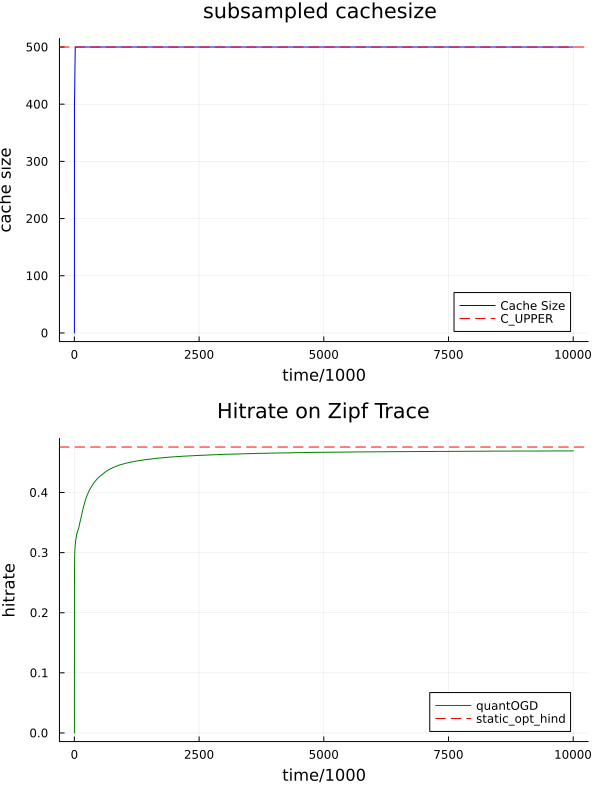

In [7]:
function zipf_hitrate_plt(; T=10^5, N=10^4, alpha=1.0, C=div(10^4, 20))
    q, zipf_trace = zipf_setup(T=T, N=N, alpha=alpha, C=C, CACHE_FLAG = true)
    hit = 0.0
    hits = zeros(Float32, length(zipf_trace))
    cachesizes = zeros(Float32, length(zipf_trace))

    for i in 1:length(zipf_trace)
        j = zipf_trace[i]
        hit += (j in q.cache) ? 1 : 0
        hits[i] = hit
        cachesizes[i] = length(q.cache)
        step!(q, j)
    end
    ss = div(length(hits), 10^4)  # this for subsampling  
    # Compute the moving maximum over the cachesizes array using the specified window.
    # mov_max = [maximum(cachesizes[max(1, i - window + 1):i]) for i in 1:length(cachesizes)]

    # First plot: moving maximum of the cache sizes.
    p1 = plot(cachesizes[1:ss:end],
        label="Cache Size",
        color=:blue,
        xlabel="time/$ss",
        ylabel="cache size",
        title="subsampled cachesize ")
    hline!(p1, [q.C_UPPER],
        label="C_UPPER",
        color=:red,
        linestyle=:dash)

    # Calculate opt (static optimal hitrate)
    opt = mean(zipf_trace .<= C)
    # Generate the decay curve: cumulative hitrate over time.
    decay_curve = hits ./ (1:length(zipf_trace))

    # Second plot: hitrate decay curve.
    p2 = plot(decay_curve[1:ss:end],
        label="quantOGD",
        color=:green,
        xlabel="time/$ss",
        ylabel="hitrate",
        title="Hitrate on Zipf Trace")
    hline!(p2, [opt],
        label="static_opt_hind",
        color=:red,
        linestyle=:dash)

    # Stack the two plots vertically.
    p = plot(p1, p2, layout=(2, 1), size=(600, 800))
    display(p)
end

N = 10^4
C = div(N, 20)
println("C=",C)
zipf_hitrate_plt(T=10^7, N=N, alpha=0.8, C=C)

step_size is capped at 10 for performance reasons
step_size: 2
final hitrate:0.096708


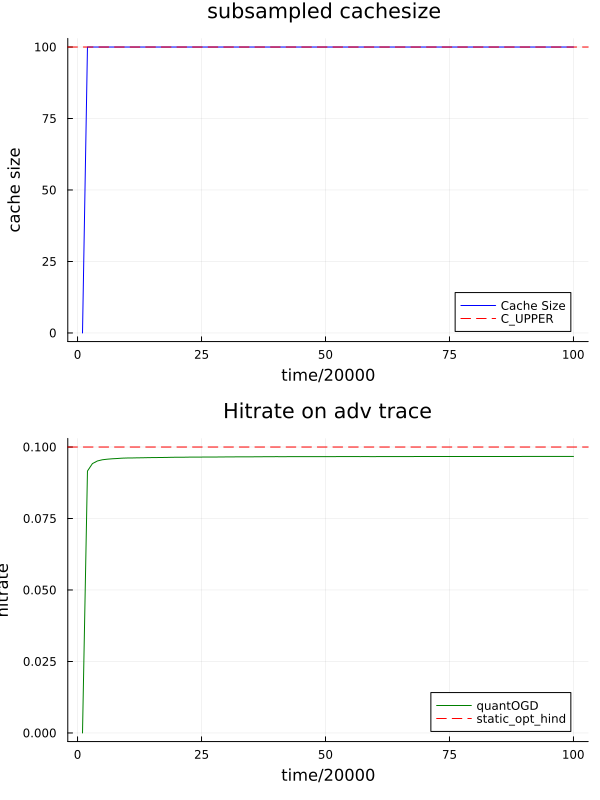

In [29]:
using Random
function adv_hitrate_plt(; rep= 1000, alpha=1.0, C=500, window=1000)

    tmp = collect(1:1000)
    l = [] 
    for _ in 1:rep
        append!(l,shuffle(tmp))
    end
    l = [ Int(x) for x in l]

    T = length(l)
    N = 1000
    hit = 0.0
    hits = zeros(Float32, length(l))
    cachesizes = zeros(Float32, length(l))

    q, zipf_trace = zipf_setup(T=T, N=N, alpha=alpha, C=C, CACHE_FLAG = true)

    for i in 1:length(l)
        j = l[i]
        hit += (j in q.cache) ? 1 : 0
        hits[i] = hit
        cachesizes[i] = length(q.cache)
        step!(q, j)
    end
    ss = div(length(hits), 10^2)  # this for subsampling  
    # Compute the moving maximum over the cachesizes array using the specified window.
    # mov_max = [maximum(cachesizes[max(1, i - window + 1):i]) for i in 1:length(cachesizes)]

    # First plot: moving maximum of the cache sizes.
    p1 = plot(cachesizes[1:ss:end],
        label="Cache Size",
        color=:blue,
        xlabel="time/$ss",
        ylabel="cache size",
        title="subsampled cachesize ")
    hline!(p1, [q.C_UPPER],
        label="C_UPPER",
        color=:red,
        linestyle=:dash)

    # Calculate opt (static optimal hitrate)
    opt = C/N 
    # Generate the decay curve: cumulative hitrate over time.
    hit_rates = hits ./ (1:length(l))

    # Second plot: hitrate decay curve.
    p2 = plot(hit_rates[1:ss:end],
        label="quantOGD",
        color=:green,
        xlabel="time/$ss",
        ylabel="hitrate",
        title="Hitrate on adv trace")
    hline!(p2, [opt],
        label="static_opt_hind",
        color=:red,
        linestyle=:dash)

    # Stack the two plots vertically.
    p = plot(p1, p2, layout=(2, 1), size=(600, 800))
    display(p)
    println("final hitrate:", hit_rates[end])
end
adv_hitrate_plt(rep= 2000, C = 100)